In [1]:
# %autosave 60
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os, sys, traceback
os.environ["OPENBLAS_NUM_THREADS"] = "16"

from copy import deepcopy as copy
import numpy as np
from astropy.io import fits
import astropy.units as u
import astropy.constants as const
from astropy.cosmology import WMAP9 as cosmo
import matplotlib.pyplot as plt

The example uses S3Fit v2.0.

In [2]:
# sys.path.append(os.path.abspath("/lwk/xychen/AKARI_ULIRG/SEDFit/s3fit")) # comment this line if you install with pip
from s3fit.fit_frame import FitFrame

v2.0, 250204: (1) Split into multiple files; (2) Support pip installation


# Example data

Input spectral data

In [3]:
example_spec_tw = fits.open('example_spec_tw.fits')[0].data
spec_wave_w = example_spec_tw[0]
spec_flux_w = example_spec_tw[1]
spec_ferr_w = example_spec_tw[2]

spec_valid_range = [[4950, 5074], [5120, 5240], [5280, 6420], [6500, 10050]]
spec_R_inst = 631 / 0.31 * 0.5
spec_flux_scale = 1e-15

v0_redshift = 0.4684

Input photometric data

In [4]:
phot_name_b = np.array(['SDSS_up', 'SDSS_gp', 'SDSS_rp', 'SDSS_ip', 'SDSS_zp', '2MASS_J',
       '2MASS_H', '2MASS_Ks', 'WISE_1', 'WISE_2', 'WISE_3', 'WISE_4'])
phot_flux_b = np.array([5.5153001e-02, 8.1697002e-02, 1.6868000e-01, 2.3030201e-01,
       2.9083699e-01, 2.6506501e-01, 5.1317799e-01, 6.0935998e-01,
       6.5717798e-01, 7.9932898e-01, 1.6560427e+01, 9.2305588e+01])
phot_ferr_b = np.array([5.37700020e-04, 7.42999837e-05, 7.90003687e-05, 1.22798607e-04,
       1.38930045e-03, 4.11554985e-02, 2.27502026e-02, 1.14961006e-01,
       2.30419636e-03, 2.99510360e-03, 3.06923389e-02, 3.02008629e-01])

phot_trans_dir='../filters/'

# Set models

Use two-component SFH: exponential SFH for the main population and constant SFH for young population

In [5]:
ssp_config = {'main': {'pars': [[-1000, 1000, 'free'], [100, 1200, 'free'], [0, 5.0, 'free'], 
                                [0, 0.94, 'free'], [-1, 1, 'free']], 
                       'info': {'age_min': -2.25, 'age_max': 'universe', 'met_sel': 'solar', 'sfh_name': 'exponential'} }, 
              'young': {'pars': [[None, None, 'ssp:main:0'], [None, None, 'ssp:main:1'], [None, None, 'ssp:main:2'], 
                                 [-2, -1, 'free'], [-1, -1, 'fix']], 
                        'info': {'age_min': -2.25, 'age_max': 0, 'met_sel': 'solar', 'sfh_name': 'constant'} } }
# pars: voff, fwhm, AV, log csp_age (Gyr), log sfh_tau (Gyr)
# age_min, age_max: min and max log ssp_age (Gyr)
# met_sel: 'all', 'solar', or any combination of [0.004,0.008,0.02,0.05]
# sfh: 'nonparametric', 'exponential', 'delayed', 'constant'
ssp_file = '../models/popstar_for_s3fit.fits'
# please use ../models/convert_popstar_ssp.py to create the ssp template library

Use three components of emssion lines, one for narrow lines and the other two for broad (outflow) lines. 
Limit the line names for the 2nd outflow component. 

In [6]:
el_config = {'NLR': {'pars':       [[ -500,   500, 'free'], [250,  750, 'free'], [0, 5, 'free'], [1.3, 4.3, 'free'], [4, None, 'fix']], 
                     'info': {'line_used': ['all']}}, 
             'outflow_1': {'pars': [[-2000,   100, 'free'], [750, 2500, 'free'], [0, 5, 'free'], [1.3, 4.3, 'free'], [4, None, 'fix']], 
                           'info': {'line_used': ['all']}}, 
             'outflow_2': {'pars': [[-3000, -2000, 'free'], [750, 2500, 'free'], [0, 5, 'free'], [1.3, 4.3, 'free'], [4, None, 'fix']], 
                           'info': {'line_used': ['[O III]:4960', '[O III]:5008', '[N II]:6550', 'Ha', '[N II]:6585']} } }
# pars: voff, fwhm, AV, SIIa/b (n_e: 1e4--1cm-3); 3 kinematic system

Set configurations for AGN powerlaw and torus component. 

In [7]:
agn_config = {'main': {'pars': [[None, None, 'el:NLR:0;ssp:main:0'], [None, None, 'el:NLR:1;ssp:main:1'], [1.5, 10.0, 'free'], [-1.7, None, 'fix']],
                       'info': {'mod_used': ['powerlaw']} } }
# pars: voff, fwhm, AV; alpha_lambda of powerlaw at 

torus_config = {'main': {'pars': [[None, None, 'el:NLR:0;ssp:main:0'], [3, 11, 'free'], [10, 80, 'free'], [10, 30, 'free'], [0, 90, 'free']],
                         'info': {'mod_used': ['dust']} } } # 
# pars: voff, tau, opening angle, radii ratio, inclination angle
# set 'mod_used' to ['disc', 'dust'] if use both of disc and dusty torus modules
torus_file = '../models/skirtor_for_s3fit.fits'
# please use ../models/convert_skirtor_torus.py to create the torus library

Summarize configurations for all models. Comment the model not required, e.g., 
AGN powerlaw is not required in this case since the example is type-2. 

Set 'use_pyneb' to False if PyNeb is not installed.

In [8]:
model_config = {'ssp': {'enable': True, 'config': ssp_config, 'file': ssp_file}, 
                'el': {'enable': True, 'config': el_config, 'use_pyneb': True}, 
#                 'agn': {'enable': True, 'config': agn_config}, 
                'torus': {'enable': True, 'config': torus_config, 'file': torus_file}}

# Pure spec fit

In the first case, try the fitting only for spectral data. 

Initialize the FitFrame

In [15]:
FF_noSED_biSFH = FitFrame(spec_wave_w=spec_wave_w, spec_flux_w=spec_flux_w, spec_ferr_w=spec_ferr_w, 
                    spec_valid_range=spec_valid_range, spec_R_inst=spec_R_inst, spec_flux_scale=spec_flux_scale, 
                    # phot_name_b=phot_name_b, phot_flux_b=phot_flux_b, phot_ferr_b=phot_ferr_b, phot_trans_dir=phot_trans_dir,
                    # comment phot line if only spectral fitting is required
                    v0_redshift=v0_redshift, model_config=model_config,
                    num_mock_loops=0, fit_grid='log', 
                    plot_step=True, print_step=False, verbose=False)
                    # set num_mock_loops=0 to only fit the raw data, i.e., no mocked spectra
                    # set plot=True to plot each fitting step

Spec models wavelength range (rest): 2972.201827240925 7484.315237939023
SSP models normalization wavelength: 5500 +- 25
SSP models number: 73 used in 424
SSP models age range (Gyr): 0.005754399373371567 7.943282347242822
SSP models metallicity (Z/H): [0.02]
SFH pattern: ['exponential' 'constant']
Emission line comp0:'NLR',  23 lines in total,  11 free lines: ['[Ne V]:3427' '[O II]:3730' '[Ne III]:3870' '[O III]:5008' '[Fe VI]:5099'
 '[N I]:5202' 'He I:5877' '[O I]:6302' 'Ha' '[N II]:6585' '[S II]:6733']
Emission line comp1:'outflow_1',  23 lines in total,  11 free lines: ['[Ne V]:3427' '[O II]:3730' '[Ne III]:3870' '[O III]:5008' '[Fe VI]:5099'
 '[N I]:5202' 'He I:5877' '[O I]:6302' 'Ha' '[N II]:6585' '[S II]:6733']
Emission line comp2:'outflow_2',  5 lines in total,  3 free lines: ['[O III]:5008' 'Ha' '[N II]:6585']
#### Models used in the fitting: ssp+el+torus ####


Run fit

#### loop 0/1 start: ####
#### fit the raw spectrum (non-mocked) ####
1 loops have good fit, chi_sq: [1.94754402]
0 loops need refit, chi_sq: []
#### loop 0/1 end, 124.0 s ####
######## 1 successful loops in total 1 loops ########

Best-fit stellar properties of the <main> component with exponential SFH.
| Chi^2 of best-fit                =     1.9475
| Redshift                         =     0.4685 +/- nan
| Velocity dispersion (km/s)       =   377.4779 +/- nan
| Extinction (AV)                  =     1.4252 +/- nan
| log Age_max of CSP (Gyr)         =     0.7429 +/- nan
| log Tau of SFH (Gyr)             =    -0.4951 +/- nan
| F5500(rest) (1e-15 erg/s/cm2/AA) =     0.0042 +/- nan
| log L5500(rest) (Lsun/AA)        =     6.7024 +/- nan
| log Mass (all formed) (Msun)     =    11.0336 +/- nan
| log Mass (remainning) (Msun)     =    10.8322 +/- nan
| log M/L5500 (Msun/(Lsun/AA))     =     4.1299 +/- nan
| Lum-weight log Age (Gyr)         =     0.7275 +/- nan
| Mass-weight log Age (Gyr)   

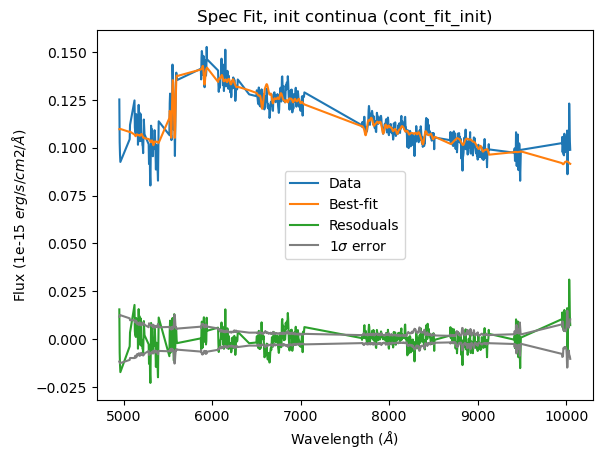

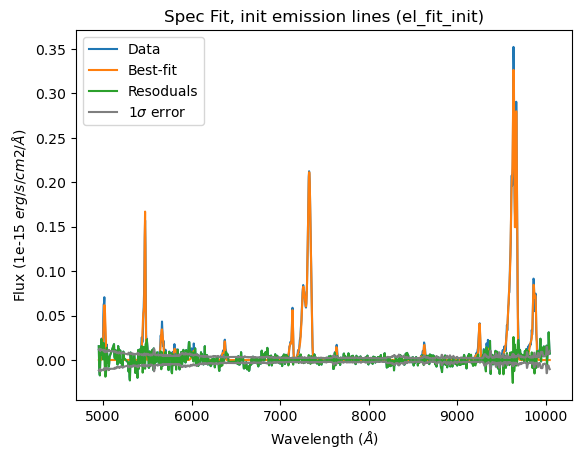

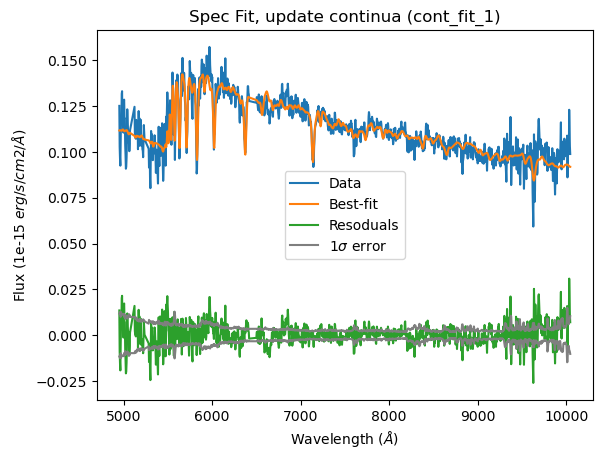

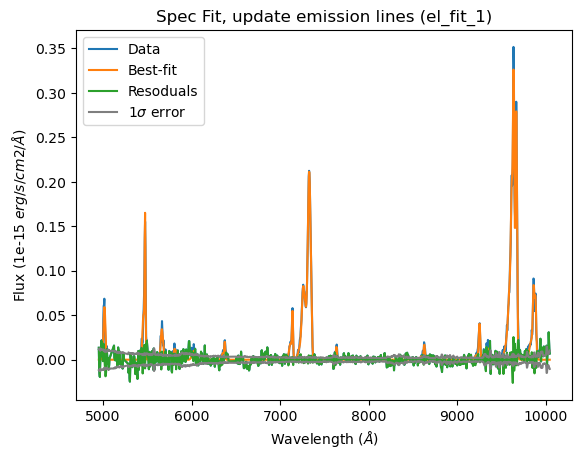

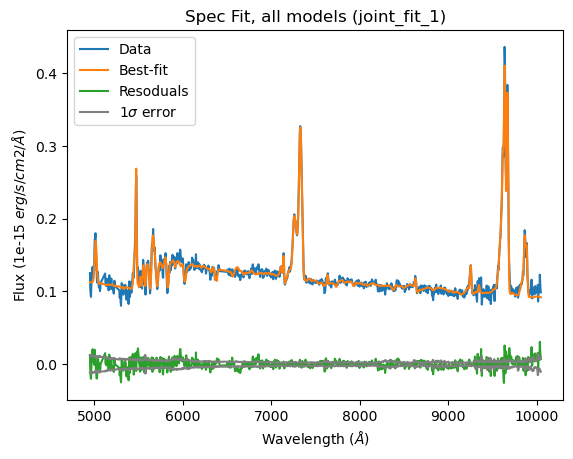

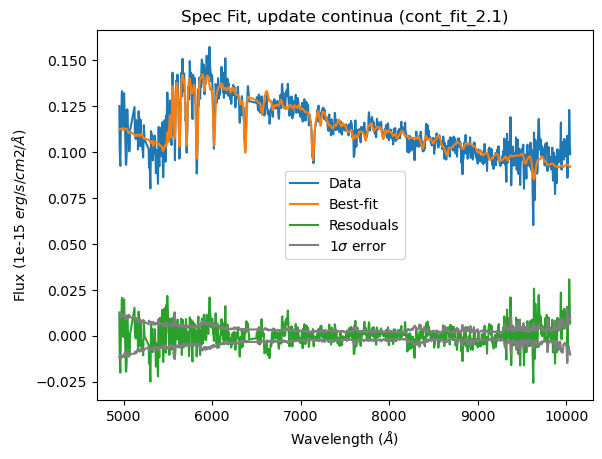

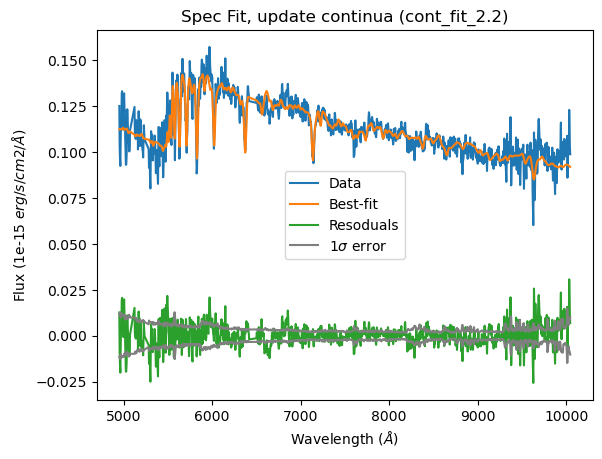

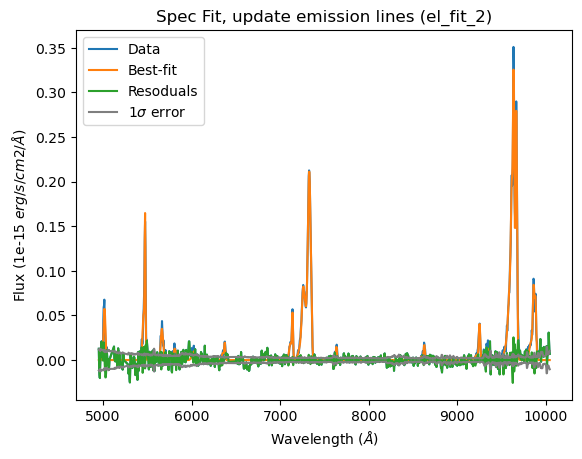

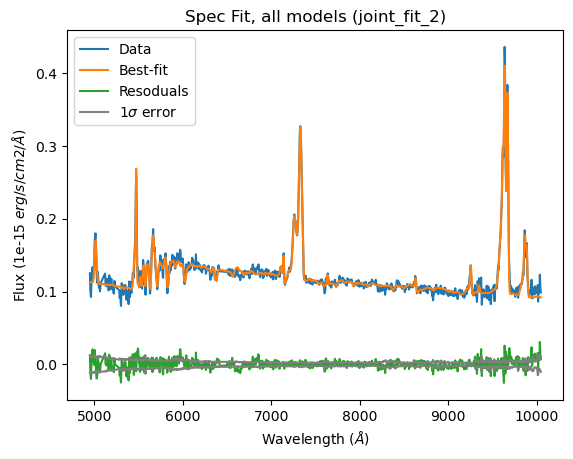

In [16]:
FF_noSED_biSFH.main_fit()

# Spec + SED fit

Now try the simualtaneous fit for both of spectral and photometric SED.

In [17]:
FF_wSED_biSFH = FitFrame(spec_wave_w=spec_wave_w, spec_flux_w=spec_flux_w, spec_ferr_w=spec_ferr_w, 
                    spec_valid_range=spec_valid_range, spec_R_inst=spec_R_inst, spec_flux_scale=spec_flux_scale, 
                    phot_name_b=phot_name_b, phot_flux_b=phot_flux_b, phot_ferr_b=phot_ferr_b, phot_trans_dir=phot_trans_dir,
                    # comment phot line if only spectral fitting is required
                    v0_redshift=v0_redshift, model_config=model_config,
                    num_mock_loops=0, fit_grid='log', 
                    plot_step=True, print_step=False, verbose=False)
                    # num_mock_loops=0 to only fit the raw data, i.e., no mocked spectra
                    # set plot=True to plot each fitting step

Photometric data in bands: ['SDSS_up' 'SDSS_gp' 'SDSS_rp' 'SDSS_ip' 'SDSS_zp' '2MASS_J' '2MASS_H'
 '2MASS_Ks' 'WISE_1' 'WISE_2' 'WISE_3' 'WISE_4']
Spec models wavelength range (rest): 2972.201827240925 7484.315237939023
SED models wavelength range (rest): 1649.891797813306 239970.85955593377
SSP models normalization wavelength: 5500 +- 25
SSP models number: 73 used in 424
SSP models age range (Gyr): 0.005754399373371567 7.943282347242822
SSP models metallicity (Z/H): [0.02]
SFH pattern: ['exponential' 'constant']
Emission line comp0:'NLR',  23 lines in total,  11 free lines: ['[Ne V]:3427' '[O II]:3730' '[Ne III]:3870' '[O III]:5008' '[Fe VI]:5099'
 '[N I]:5202' 'He I:5877' '[O I]:6302' 'Ha' '[N II]:6585' '[S II]:6733']
Emission line comp1:'outflow_1',  23 lines in total,  11 free lines: ['[Ne V]:3427' '[O II]:3730' '[Ne III]:3870' '[O III]:5008' '[Fe VI]:5099'
 '[N I]:5202' 'He I:5877' '[O I]:6302' 'Ha' '[N II]:6585' '[S II]:6733']
Emission line comp2:'outflow_2',  5 lines in total,  

Run fit

#### loop 0/1 start: ####
#### fit the raw spectrum (non-mocked) ####
1 loops have good fit, chi_sq: [0.16348526]
0 loops need refit, chi_sq: []
#### loop 0/1 end, 125.9 s ####
######## 1 successful loops in total 1 loops ########

Best-fit stellar properties of the <main> component with exponential SFH.
| Chi^2 of best-fit                =     0.1635
| Redshift                         =     0.4684 +/- nan
| Velocity dispersion (km/s)       =   358.5032 +/- nan
| Extinction (AV)                  =     1.2330 +/- nan
| log Age_max of CSP (Gyr)         =     0.4233 +/- nan
| log Tau of SFH (Gyr)             =     0.6410 +/- nan
| F5500(rest) (1e-15 erg/s/cm2/AA) =     0.0255 +/- nan
| log L5500(rest) (Lsun/AA)        =     7.4109 +/- nan
| log Mass (all formed) (Msun)     =    11.1120 +/- nan
| log Mass (remainning) (Msun)     =    10.9773 +/- nan
| log M/L5500 (Msun/(Lsun/AA))     =     3.5664 +/- nan
| Lum-weight log Age (Gyr)         =    -0.3166 +/- nan
| Mass-weight log Age (Gyr)   

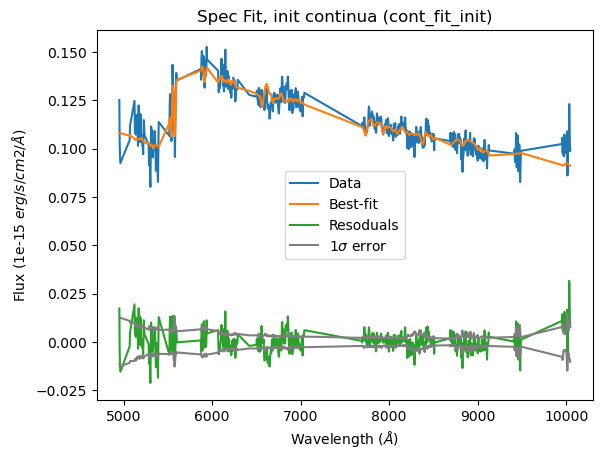

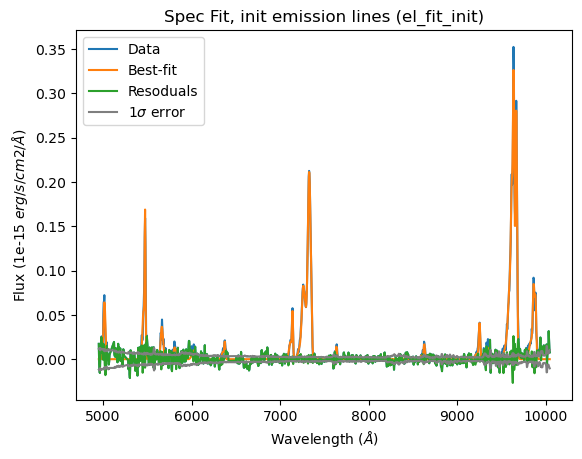

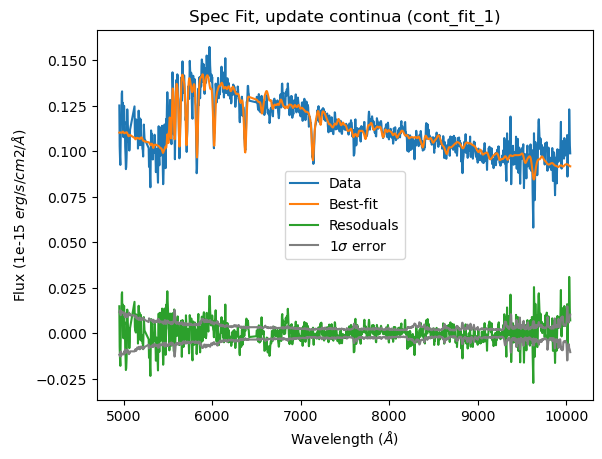

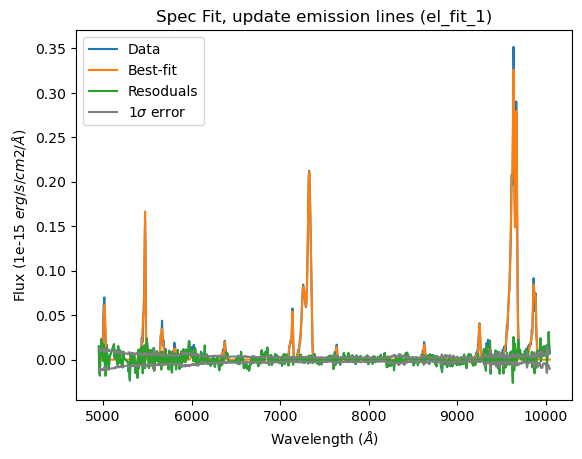

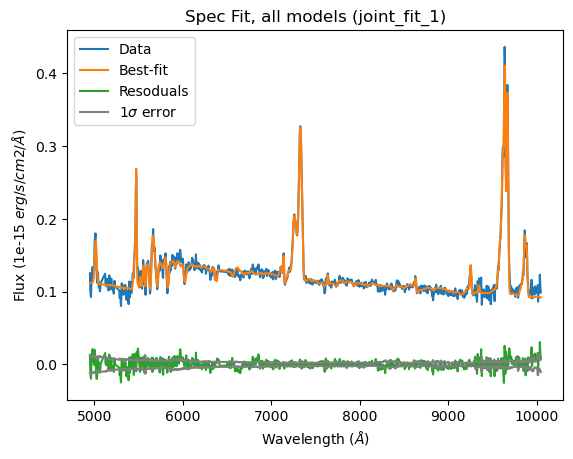

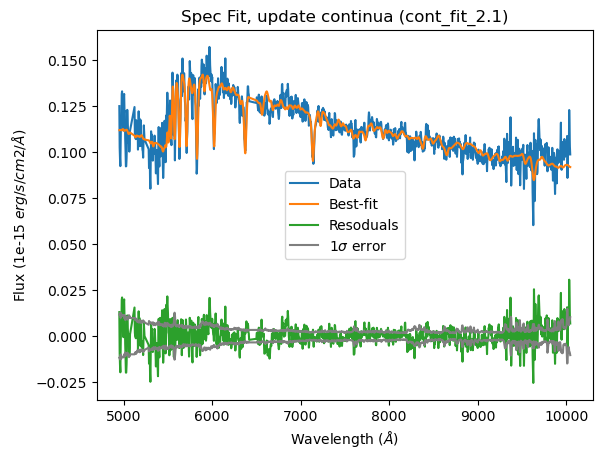

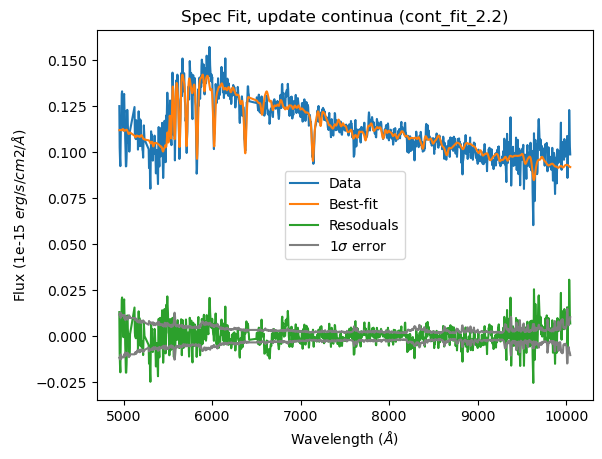

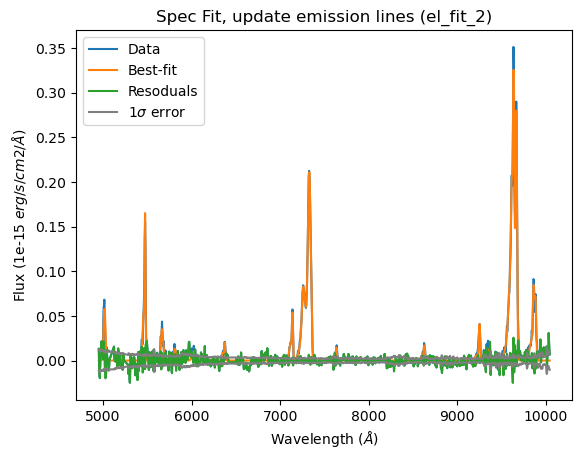

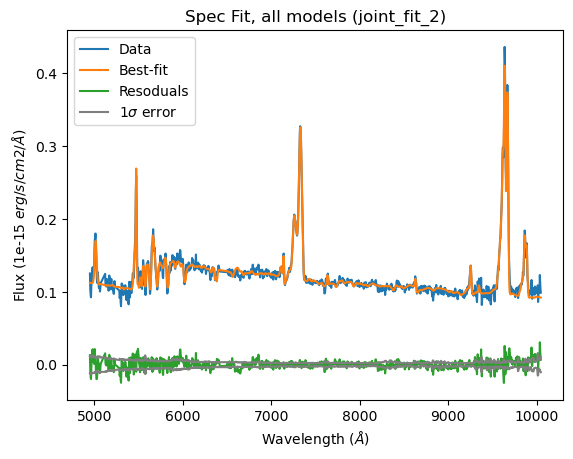

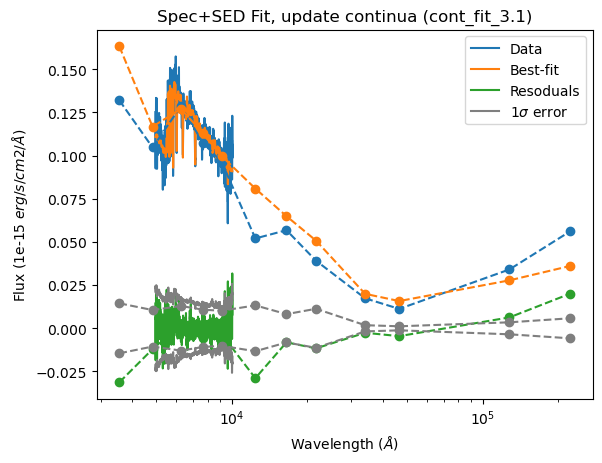

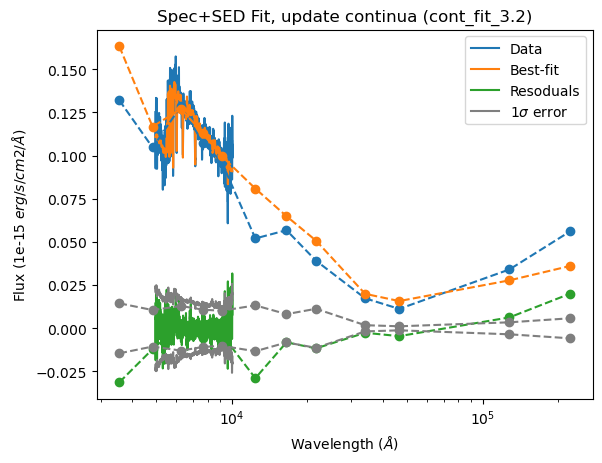

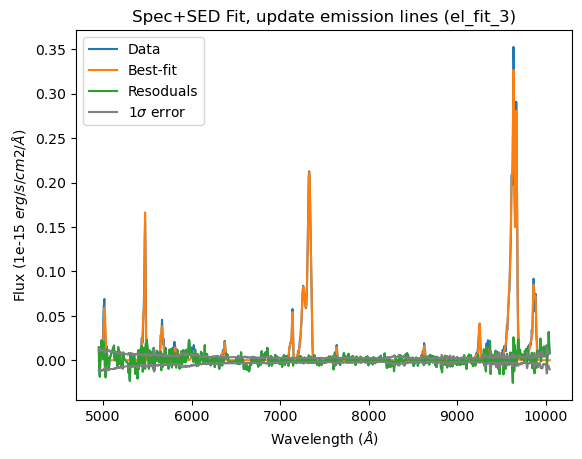

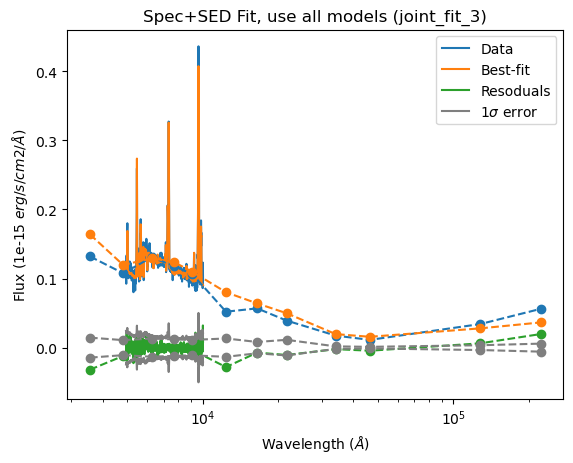

In [18]:
FF_wSED_biSFH.main_fit()

You may note that the best Spec+SED fit has a small chi-square of 0.16, which is due to the enlarged errors in the fitting (i.e., by adding 10% flux) to account for the calibration uncertainty between instruments. To be compared, the pure spectral fit above has a chi-square of 1.95 calculated with the original measurement errors.

# Spec + SED fit with mocked spectra (for uncertainty estimation)

In [19]:
FF_wSED_biSFH_mock10 = FitFrame(spec_wave_w=spec_wave_w, spec_flux_w=spec_flux_w, spec_ferr_w=spec_ferr_w, 
                    spec_valid_range=spec_valid_range, spec_R_inst=spec_R_inst, spec_flux_scale=spec_flux_scale, 
                    phot_name_b=phot_name_b, phot_flux_b=phot_flux_b, phot_ferr_b=phot_ferr_b, phot_trans_dir=phot_trans_dir,
                    # comment phot line if only spectral fitting is required
                    v0_redshift=v0_redshift, model_config=model_config,
                    num_mock_loops=10, plot_step=False, print_step=False, verbose=False)
                    # set num_mock_loops=10 to create 10 mocked spectra

Photometric data in bands: ['SDSS_up' 'SDSS_gp' 'SDSS_rp' 'SDSS_ip' 'SDSS_zp' '2MASS_J' '2MASS_H'
 '2MASS_Ks' 'WISE_1' 'WISE_2' 'WISE_3' 'WISE_4']
Spec models wavelength range (rest): 2972.201827240925 7484.315237939023
SED models wavelength range (rest): 1649.891797813306 239970.85955593377
SSP models normalization wavelength: 5500 +- 25
SSP models number: 73 used in 424
SSP models age range (Gyr): 0.005754399373371567 7.943282347242822
SSP models metallicity (Z/H): [0.02]
SFH pattern: ['exponential' 'constant']
Emission line comp0:'NLR',  23 lines in total,  11 free lines: ['[Ne V]:3427' '[O II]:3730' '[Ne III]:3870' '[O III]:5008' '[Fe VI]:5099'
 '[N I]:5202' 'He I:5877' '[O I]:6302' 'Ha' '[N II]:6585' '[S II]:6733']
Emission line comp1:'outflow_1',  23 lines in total,  11 free lines: ['[Ne V]:3427' '[O II]:3730' '[Ne III]:3870' '[O III]:5008' '[Fe VI]:5099'
 '[N I]:5202' 'He I:5877' '[O I]:6302' 'Ha' '[N II]:6585' '[S II]:6733']
Emission line comp2:'outflow_2',  5 lines in total,  

In [20]:
FF_wSED_biSFH_mock10.main_fit()

#### loop 0/11 start: ####
#### fit the raw spectrum (non-mocked) ####
#### loop 0/11 end, 161.4 s ####
#### loop 1/11 start: ####
#### fit the mocked spectrum ####
#### loop 1/11 end, 135.4 s ####
#### loop 2/11 start: ####
#### fit the mocked spectrum ####
#### loop 2/11 end, 150.6 s ####
#### loop 3/11 start: ####
#### fit the mocked spectrum ####
#### loop 3/11 end, 130.9 s ####
#### loop 4/11 start: ####
#### fit the mocked spectrum ####
#### loop 4/11 end, 63.6 s ####
#### loop 5/11 start: ####
#### fit the mocked spectrum ####
#### loop 5/11 end, 165.7 s ####
#### loop 6/11 start: ####
#### fit the mocked spectrum ####
#### loop 6/11 end, 123.5 s ####
#### loop 7/11 start: ####
#### fit the mocked spectrum ####
#### loop 7/11 end, 208.1 s ####
#### loop 8/11 start: ####
#### fit the mocked spectrum ####
#### loop 8/11 end, 99.4 s ####
#### loop 9/11 start: ####
#### fit the mocked spectrum ####
#### loop 9/11 end, 141.2 s ####
#### loop 10/11 start: ####
#### fit the mocked spec

You may also run another fit with a different SFH, e.g., nonparametric SFH.

Set a new ssp_config and update model_config:

In [21]:
ssp_config = {'main': {'pars': [[-1000, 1000, 'free'], [100, 1200, 'free'], [0, 5.0, 'free'], [-1, -1, 'fix'], [-1, -1, 'fix']], 
                       'info': {'age_min': -2.25, 'age_max': 'universe', 'met_sel': 'solar', 'sfh_name': 'nonparametric'} } }
model_config['ssp'] = {'enable': True, 'config': ssp_config, 'file': ssp_file}

In [22]:
FF_wSED_npSFH_mock10 = FitFrame(spec_wave_w=spec_wave_w, spec_flux_w=spec_flux_w, spec_ferr_w=spec_ferr_w, 
                    spec_valid_range=spec_valid_range, spec_R_inst=spec_R_inst, spec_flux_scale=spec_flux_scale, 
                    phot_name_b=phot_name_b, phot_flux_b=phot_flux_b, phot_ferr_b=phot_ferr_b, phot_trans_dir=phot_trans_dir,
                    # comment phot line if only spectral fitting is required
                    v0_redshift=v0_redshift, model_config=model_config,
                    num_mock_loops=10, plot_step=False, print_step=False, verbose=False)
                    # set num_mock_loops=10 to create 10 mocked spectra

Photometric data in bands: ['SDSS_up' 'SDSS_gp' 'SDSS_rp' 'SDSS_ip' 'SDSS_zp' '2MASS_J' '2MASS_H'
 '2MASS_Ks' 'WISE_1' 'WISE_2' 'WISE_3' 'WISE_4']
Spec models wavelength range (rest): 2972.201827240925 7484.315237939023
SED models wavelength range (rest): 1649.891797813306 239970.85955593377
SSP models normalization wavelength: 5500 +- 25
SSP models number: 73 used in 424
SSP models age range (Gyr): 0.005754399373371567 7.943282347242822
SSP models metallicity (Z/H): [0.02]
SFH pattern: ['nonparametric']
Emission line comp0:'NLR',  23 lines in total,  11 free lines: ['[Ne V]:3427' '[O II]:3730' '[Ne III]:3870' '[O III]:5008' '[Fe VI]:5099'
 '[N I]:5202' 'He I:5877' '[O I]:6302' 'Ha' '[N II]:6585' '[S II]:6733']
Emission line comp1:'outflow_1',  23 lines in total,  11 free lines: ['[Ne V]:3427' '[O II]:3730' '[Ne III]:3870' '[O III]:5008' '[Fe VI]:5099'
 '[N I]:5202' 'He I:5877' '[O I]:6302' 'Ha' '[N II]:6585' '[S II]:6733']
Emission line comp2:'outflow_2',  5 lines in total,  3 free li

Run fit (skip the output here)

In [24]:
# FF_wSED_npSFH_mock10.main_fit()

# Output best-fit spectra

Use the case `FF_wSED_biSFH_mock10` for an example.

In [35]:
FF = copy(FF_wSED_biSFH_mock10)

The best-fit spectra are stored in `FF.spec` and `FF.sed`.
`FF.spec` is in the range of the observed spectrum; `FF.sed` is in the range of the full SED.

In [25]:
print(f"Names of available best-fit model spectra: {[name for name in [*FF.spec] if name[:4] == 'fmod']}")

Names of available best-fit model spectra: ['fmod_ssp_w', 'fmod_el_w', 'fmod_torus_w', 'fmod_tot_w']


`FF.spec['fmod_ssp_w']` is the sum of all stellar continuum components. 
Here create stellar continuum spectra of each component. 
The components are set in the input `ssp_config`.

In [26]:
ssp_mod, ssp_cf = FF.model_dict['ssp']['specmod'], FF.model_dict['ssp']['cf']
fx0, fx1, fc0, fc1 = FF.model_index('ssp', FF.full_model_type)

i_l = 0 # show the first loop, i.e., the fit for raw data (i_l > 1 for mocked ones)

ssp_spec_mw = FF.model_dict['ssp']['specfunc'](FF.spec['wave_w'], FF.best_fits_x[i_l, fx0:fx1])
ssp_sed_mw = FF.model_dict['ssp']['sedfunc'](FF.sed['wave_w'], FF.best_fits_x[i_l, fx0:fx1])
ssp_spec_w = {}; ssp_sed_w = {}; i_m0 = 0; i_m1 = 0
for i_c in range(ssp_cf.num_comps):
    i_m1 += int(ssp_mod.num_coeffs / ssp_cf.num_comps)
    i_m0 += 0 if i_c == 0 else int(ssp_mod.num_coeffs / ssp_cf.num_comps)
    ssp_spec_w[ssp_cf.comp_c[i_c]] = np.dot(FF.best_coeffs[i_l, fc0:fc1][i_m0:i_m1], ssp_spec_mw[i_m0:i_m1])
    ssp_sed_w[ssp_cf.comp_c[i_c]]  = np.dot(FF.best_coeffs[i_l, fc0:fc1][i_m0:i_m1], ssp_sed_mw[i_m0:i_m1])

`FF.spec['fmod_el_w']` is the sum of all emission line components.
Here create emission line spectra of each component. 
The components are set in the input `el_config`.

In [27]:
el_mod, el_cf = FF.model_dict['el']['specmod'], FF.model_dict['el']['cf']
fx0, fx1, fc0, fc1 = FF.model_index('el', FF.full_model_type)

i_l = 0 # show the first loop, i.e., the fit for raw data (i_l > 1 for mocked ones)

el_spec_mw = FF.model_dict['el']['specfunc'](FF.spec['wave_w'], FF.best_fits_x[i_l, fx0:fx1])
el_spec_w = {}; i_m0 = 0; i_m1 = 0
for i_c in range(el_cf.num_comps):
    i_m1 += el_mod.mask_free_cn[i_c].sum()
    i_m0 += 0 if i_c == 0 else el_mod.mask_free_cn[i_c-1].sum()
    el_spec_w[el_cf.comp_c[i_c]] = np.dot(FF.best_coeffs[i_l, fc0:fc1][i_m0:i_m1], el_spec_mw[i_m0:i_m1])

Plot the best-fit spectra in the wavelength range of the data spectrum.

Text(0.5, 1.0, 'The best-fit spectra in the wavelength range of the data spectrum.')

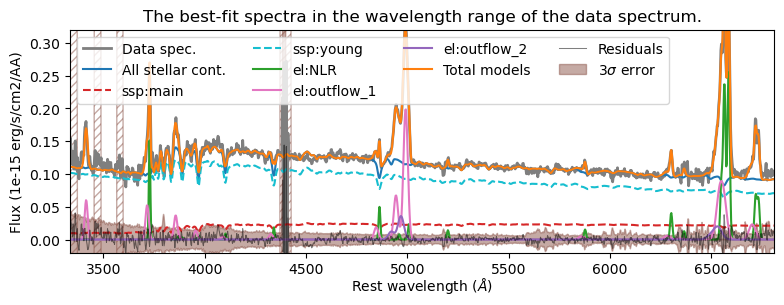

In [28]:
tmp_z = (1+FF.v0_redshift)

plt.figure(figsize=(8,8))
plt.subplots_adjust(left=0.08,bottom=0.06,right=0.96,top=0.98,wspace=0,hspace=0.15)

ax1 = plt.subplot(3, 1, 1)
ax1.plot(FF.spec['wave_w']/tmp_z, FF.spec['flux_w'] , c='C7', linewidth=2, label='Data spec.')
ax1.plot(FF.spec['wave_w']/tmp_z, FF.spec['fmod_ssp_w'], c='C0', label='All stellar cont.')
colors = ['C3', 'C9']
for i_c in range(ssp_cf.num_comps):
    ax1.plot(FF.spec['wave_w']/tmp_z, ssp_spec_w[ssp_cf.comp_c[i_c]], '--', c=colors[i_c], label='ssp:'+ssp_cf.comp_c[i_c] )

# plt.plot(FF.spec['wave_w']/tmp_z, FF.spec['fmod_el_w'], c='C3', label='All emission lines')
colors = ['C2', 'C6', 'C4']
for i_c in range(el_cf.num_comps):
    ax1.plot(FF.spec['wave_w']/tmp_z, el_spec_w[el_cf.comp_c[i_c]], c=colors[i_c], label='el:'+el_cf.comp_c[i_c] )

ax1.plot(FF.spec['wave_w']/tmp_z, FF.spec['fmod_tot_w'], c='C1', label='Total models')
ax1.plot(FF.spec['wave_w']/tmp_z, FF.spec['fres_w'], c='k', linewidth=.75, alpha=.5, label='Residuals')
ax1.fill_between(FF.spec['wave_w']/tmp_z, -3*FF.spec['ferr_w'], 3*FF.spec['ferr_w'], 
                 fc='C5', ec='C5', alpha=0.5, label='3$\sigma$ error')
ax1.fill_between(FF.spec['wave_w']/tmp_z, -1*~FF.spec['mask_valid_w'], 1*~FF.spec['mask_valid_w'], 
                 hatch='////', fc='None', ec='C5', alpha=0.5)

ax1.legend(ncol=4, loc=2)
ax1.set_ylim(-0.02,0.32)
ax1.set_xlim(4.9e3/tmp_z,1.0e4/tmp_z) 
ax1.set_ylabel(f'Flux ({FF.spec_flux_scale} erg/s/cm2/AA)')
ax1.set_xlabel(r'Rest wavelength ($\AA$)', labelpad=-1)
ax1.set_title('The best-fit spectra in the wavelength range of the data spectrum.')

The following plots show the best-fit model spectra in the full SED range. 
The photometric data and the corresponding model fluxes are also shown. 

Text(0.5, 0, 'Rest wavelength ($\\AA$)')

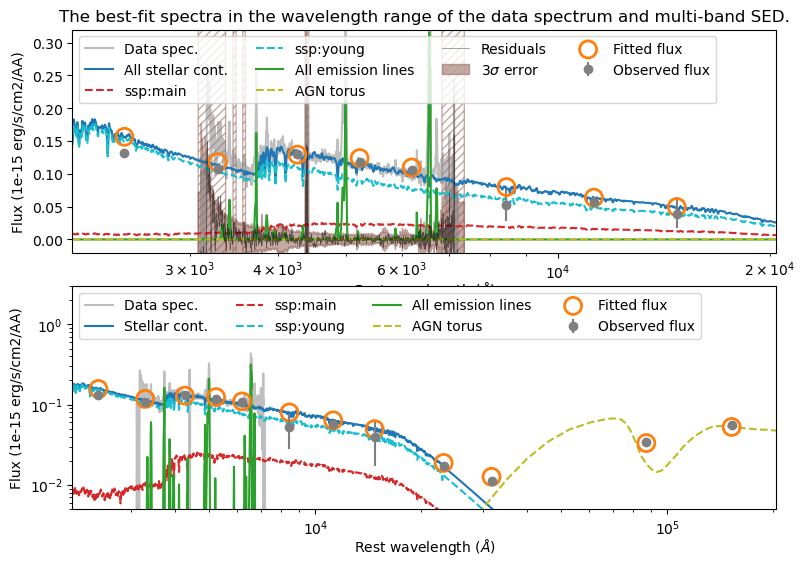

In [29]:
tmp_z = (1+FF.v0_redshift)

plt.figure(figsize=(8,8))
plt.subplots_adjust(left=0.08,bottom=0.06,right=0.96,top=0.98,wspace=0,hspace=0.15)

ax2 = plt.subplot(3, 1, 2)
ax2.plot(FF.spec['wave_w']/tmp_z, FF.spec['flux_w'] , c='C7', alpha=0.5, label='Data spec.')
ax2.plot(FF.sed['wave_w']/tmp_z, FF.sed['fmod_ssp_w'], c='C0', label='All stellar cont.')
colors = ['C3', 'C9']
for i_c in range(ssp_cf.num_comps):
    ax2.plot(FF.sed['wave_w']/tmp_z, ssp_sed_w[ssp_cf.comp_c[i_c]], '--', c=colors[i_c], label='ssp:'+ssp_cf.comp_c[i_c] )

ax2.plot(FF.sed['wave_w']/tmp_z, FF.sed['fmod_el_w'], c='C2', label='All emission lines')
ax2.plot(FF.sed['wave_w']/tmp_z, FF.sed['fmod_torus_w'], '--', c='C8', label='AGN torus')
ax2.plot(FF.spec['wave_w']/tmp_z, FF.spec['fres_w'], c='k', linewidth=.5, alpha=.5, label='Residuals')
ax2.fill_between(FF.spec['wave_w']/tmp_z, -3*FF.spec['ferr_w'], 3*FF.spec['ferr_w'], 
                 fc='C5', ec='C5', alpha=0.5, label='3$\sigma$ error')
ax2.fill_between(FF.spec['wave_w']/tmp_z, -1*~FF.spec['mask_valid_w'], 1*~FF.spec['mask_valid_w'], 
                 hatch='////', fc='None', ec='C5', alpha=0.5)

ax2.errorbar(FF.phot['wave_b']/tmp_z, FF.phot['flux_b'], FF.phot['ferr_b']*3, fmt='o', color='C7', label='Observed flux', zorder=20 )
ax2.scatter(FF.phot['wave_b']/tmp_z, FF.phot['fmod_b'], marker='o', color='None', ec='C1', s=150, linewidth=2, label='Fitted flux', zorder=20 )

ax2.legend(ncol=4, loc=2)
ax2.set_ylim(-0.02,0.32)
ax2.set_xlim(3e3/tmp_z,3e4/tmp_z) 
ax2.set_xscale('log')
ax2.set_ylabel(f'Flux ({FF.spec_flux_scale} erg/s/cm2/AA)')
ax2.set_xlabel(r'Rest wavelength ($\AA$)', labelpad=-1)
ax2.set_title('The best-fit spectra in the wavelength range of the data spectrum and multi-band SED.')

ax3 = plt.subplot(3, 1, 3)
ax3.plot(FF.spec['wave_w']/tmp_z, FF.spec['flux_w'] , c='C7', alpha=0.5, label='Data spec.')
ax3.plot(FF.sed['wave_w']/tmp_z, FF.sed['fmod_ssp_w'], c='C0', label='Stellar cont.')
colors = ['C3', 'C9']
for i_c in range(ssp_cf.num_comps):
    ax3.plot(FF.sed['wave_w']/tmp_z, ssp_sed_w[ssp_cf.comp_c[i_c]], '--', c=colors[i_c], label='ssp:'+ssp_cf.comp_c[i_c] )

ax3.plot(FF.sed['wave_w']/tmp_z, FF.sed['fmod_el_w'], c='C2', label='All emission lines')
ax3.plot(FF.sed['wave_w']/tmp_z, FF.sed['fmod_torus_w'], '--', c='C8', label='AGN torus')

ax3.errorbar(FF.phot['wave_b']/tmp_z, FF.phot['flux_b'], FF.phot['ferr_b']*3, fmt='o', color='C7', label='Observed flux', zorder=20)
ax3.scatter(FF.phot['wave_b']/tmp_z, FF.phot['fmod_b'], marker='o', color='None', ec='C1', linewidth=2, s=150, label='Fitted flux', zorder=10 )

ax3.legend(ncol=4, loc=2)
ax3.set_ylim(0.005,3)
ax3.set_xlim(3e3/tmp_z,3e5/tmp_z) 
ax3.set_yscale('log'); ax3.set_xscale('log')
ax3.set_ylabel(f'Flux ({FF.spec_flux_scale} erg/s/cm2/AA)')
ax3.set_xlabel(r'Rest wavelength ($\AA$)', labelpad=-1)

The best-fit spectra for all mocked input spectra are stored in `FF.output_spec_ltw` and `FF.output_sed_ltw`. 
`FF.output_sed_ltw[i_l, i_t, :]` is the best-fit spectra of the `(i_t)`-th model in the `(i_l)`-th mock loop.

In [30]:
print(f'i_t from 0 to {FF.output_sed_ltw.shape[1]-1} represents the model type of'
     +f" {[name[5:-2] for name in [*FF.spec] if name[:4] == 'fmod']}, respectively.")

i_t from 0 to 3 represents the model type of ['ssp', 'el', 'torus', 'tot'], respectively.


The following plots show the best-fit spectra for all mocked input spectra
in flux_lambda (left) and flux_nu (right), respectively. 

Text(0, 0.5, 'Flux (mJy))')

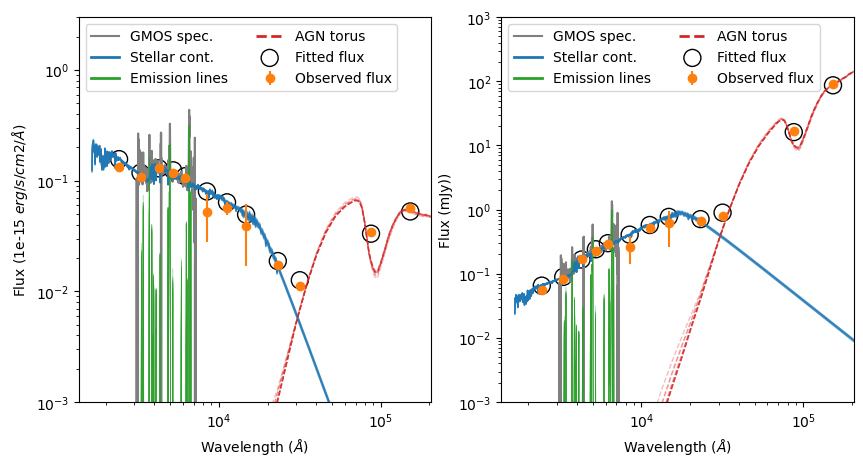

In [31]:
tmp_z = (1+FF.v0_redshift)

plt.figure(figsize=(10,5))
ax = plt.subplot(1, 2, 1)
plt.plot(FF.spec['wave_w']/tmp_z, FF.spec['flux_w'] , c='C7', label='GMOS spec.')

for i in range(FF.num_mock_loops):
    plt.plot(FF.sed['wave_w']/tmp_z, FF.output_sed_ltw[i,0,:], '-', c='C0', linewidth=1, alpha=0.3)
    plt.plot(FF.sed['wave_w']/tmp_z, FF.output_sed_ltw[i,1,:], '-', c='C2', linewidth=.5, alpha=0.3)
    plt.plot(FF.sed['wave_w']/tmp_z, FF.output_sed_ltw[i,2,:], '--', c='C3', linewidth=1, alpha=0.3)
plt.plot(0,0, '-', c='C0', linewidth=2, label='Stellar cont.')
plt.plot(0,0, '-', c='C2', linewidth=2, label='Emission lines')
plt.plot(0,0, '--', c='C3', linewidth=2, label='AGN torus')

plt.errorbar(FF.phot['wave_b']/tmp_z, FF.phot['flux_b'], FF.phot['ferr_b']*3, fmt='o', color='C1', label='Observed flux' )
plt.scatter(FF.phot['wave_b']/tmp_z, FF.phot['fmod_b'], marker='o', color='None', ec='k', s=150, label='Fitted flux')

plt.legend(ncol=2, loc=2)
plt.ylim(0.001,3); plt.xlim(2e3/tmp_z,3e5/tmp_z)
plt.yscale('log'); plt.xscale('log')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux ('+str(spec_flux_scale)+' $erg/s/cm2/\AA$)')

ax = plt.subplot(1, 2, 2)
tmp_w = spec_flux_scale * FF.pframe.rFnuFlam_func(FF.spec['wave_w']) 
plt.plot(FF.spec['wave_w']/tmp_z, FF.spec['flux_w'] * tmp_w , c='C7', label='GMOS spec.')

tmp_w = spec_flux_scale * FF.pframe.rFnuFlam_func(FF.sed['wave_w']) 
for i in range(FF.num_mock_loops):
    plt.plot(FF.sed['wave_w']/tmp_z, FF.output_sed_ltw[i,0,:] * tmp_w, '-', c='C0', linewidth=1, alpha=0.3)
    plt.plot(FF.sed['wave_w']/tmp_z, FF.output_sed_ltw[i,1,:] * tmp_w, '-', c='C2', linewidth=.5, alpha=0.3)
    plt.plot(FF.sed['wave_w']/tmp_z, FF.output_sed_ltw[i,2,:] * tmp_w, '--', c='C3', linewidth=1, alpha=0.3)
plt.plot(0,0, '-', c='C0', linewidth=2, label='Stellar cont.')
plt.plot(0,0, '-', c='C2', linewidth=2, label='Emission lines')
plt.plot(0,0, '--', c='C3', linewidth=2, label='AGN torus')

tmp_b = spec_flux_scale * FF.pframe.rFnuFlam_b
plt.errorbar(FF.phot['wave_b']/tmp_z, FF.phot['flux_b'] * tmp_b, FF.phot['ferr_b']*3 * tmp_b, fmt='o', color='C1', label='Observed flux' )
plt.scatter(FF.phot['wave_b']/tmp_z, FF.phot['fmod_b'] * tmp_b, marker='o', color='None', ec='k', s=150, label='Fitted flux')

plt.legend(ncol=2, loc=2)
plt.ylim(0.001,1000); plt.xlim(2e3/tmp_z,3e5/tmp_z)
plt.yscale('log'); plt.xscale('log')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux (mJy))')

# Output best-fit parameters

# Stellar models

Print best-fit results of stellar components with the `main(expertontial)` + `young(constant)` SFH. 

In [36]:
FF.model_dict['ssp']['specmod'].print_results()


Best-fit stellar properties of the <main> component with exponential SFH.
| Chi^2 of best-fit                =     0.1895
| Redshift                         =     0.4684 +/- 0.0001
| Velocity dispersion (km/s)       =   354.2298 +/- 13.3910
| Extinction (AV)                  =     1.3443 +/- 0.0294
| log Age_max of CSP (Gyr)         =     0.1140 +/- 0.0704
| log Tau of SFH (Gyr)             =     0.6423 +/- 0.3773
| F5500(rest) (1e-15 erg/s/cm2/AA) =     0.0211 +/- 0.0020
| log L5500(rest) (Lsun/AA)        =     7.3716 +/- 0.0354
| log Mass (all formed) (Msun)     =    10.8506 +/- 0.0627
| log Mass (remainning) (Msun)     =    10.7501 +/- 0.0568
| log M/L5500 (Msun/(Lsun/AA))     =     3.3785 +/- 0.0455
| Lum-weight log Age (Gyr)         =    -0.5676 +/- 0.0817
| Mass-weight log Age (Gyr)        =    -0.2866 +/- 0.0794
| Lum-weight log Metallicity (Z)   =    -1.6990 +/- 0.0000
| Mass-weight log Metallicity (Z)  =    -1.6990 +/- 0.0000

Best-fit stellar properties of the <young> compon

Tesults are stored in the array `FF.model_dict['ssp']['specmod'].output_ssp_lcp`.

`output_ssp_lcp[i_l, i_c, i_p]` shows the best-fit result of the `(i_p)`th value of the `(i_c)`th components in the `(i_l)`th mocked loop.

In [33]:
output_ssp_lcp = copy(FF_wSED_biSFH_mock10.model_dict['ssp']['specmod'].output_ssp_lcp)
output_ssp_vals = copy(FF_wSED_biSFH_mock10.model_dict['ssp']['specmod'].output_ssp_vals)
ssp_val_names = [*output_ssp_vals[[*output_ssp_vals][0]]['mean']]
print(f'Names of the values with i_p from 0 to {len(ssp_val_names)-1} are: {ssp_val_names}')
print()
ssp_mod = FF_wSED_biSFH_mock10.model_dict['ssp']['specmod']
print(f'Values with i_p from {len(ssp_val_names)} to {output_ssp_lcp.shape[2]} are the intrinsic flux of CSP with each metallicity, '
     +f'at rest {ssp_mod.w_norm}AA, in unit of {FF_wSED_biSFH_mock10.spec_flux_scale} erg/s/cm2/AA.')

Names of the values with i_p from 0 to 15 are: ['chi_sq', 'ssp_voff', 'ssp_fwhm', 'ssp_AV', 'sfh_par0', 'sfh_par1', 'redshift', 'flux_wavenorm', 'loglum_wavenorm', 'logmass_formed', 'logmass_remaining', 'logmtol', 'logage_lw', 'logage_mw', 'logmet_lw', 'logmet_mw']

Values with i_p from 16 to 20 are the intrinsic flux of CSP with each metallicity, at rest 5500AA, in unit of 1e-15 erg/s/cm2/AA.


In [48]:
# example
i_p = np.where(np.array(ssp_val_names) == 'redshift')[0][0]
i_c = 0 # i.e., from the first stellar component
print('Best-fit redshift from stellar continuum:', FF_wSED_biSFH_mock10.output_ssp_lcp[:,i_c,i_p].mean(), 
      '+-', FF_wSED_biSFH_mock10.output_ssp_lcp[:,i_c,i_p].std())

Best-fit redshift from stellar continuum: 0.4684123692369509 +- 6.98656226492712e-05


Plot the reconctructed SFH before and after a binning in log time. 
`num_bins` in the number of bins in the entire age range of popstar library.
The dashed (left) curves and light color bars (right) are results in each mocked loop.
The solid (left) and dark color bars (right) are averaged results. 

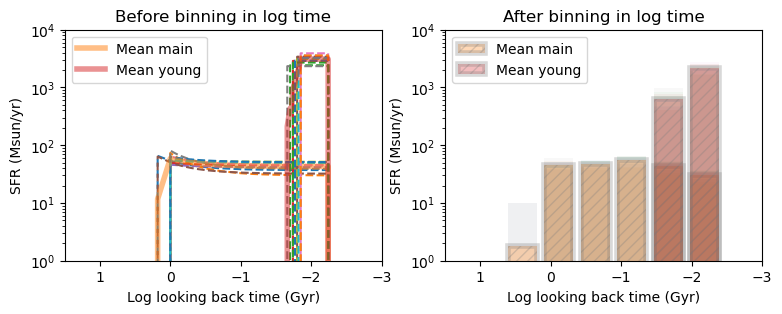

In [38]:
FF.model_dict['ssp']['specmod'].reconstruct_sfh(num_bins=10)

Output the values of SFH:

In [39]:
SFH_lcza, age_a = FF.model_dict['ssp']['specmod'].reconstruct_sfh(return_sfh=True, plot=False) # before binning
SFH_lczb, age_b = FF.model_dict['ssp']['specmod'].reconstruct_sfh(return_sfh=True, plot=False, num_bins=10) # after binning

`SFH_lcza[i_l, i_c, i_z, :]` shows the SFH with the `(i_z)`-th metallicity of the `(i_c)`-th components in the `(i_l)`-th mocked loop.
`_a` and `_b` represents the original ages and the binned ages, in log Gyr. 
Popstar SSP has four metallicities:

In [40]:
print('Available metallicities (Z):', np.unique(FF_wSED_biSFH_mock10.model_dict['ssp']['specmod'].met_m))
# in above fitting, only solar metallicity is enabled ('met_sel' in the input ssp_config)

Available metallicities (Z): [0.004 0.008 0.02  0.05 ]


Print results of stellar components with the nonparametric SFH:

In [51]:
FF_wSED_npSFH_mock10.model_dict['ssp']['specmod'].print_results()


Best-fit single stellar populations of nonparametric SFH
-----------------------------------------------------------------------
|  ID  | Age (Gyr)  | Metallicity | Coeff.mean | Coeff.rms | log(M/L) |
-----------------------------------------------------------------------
| 0236 |   0.0060   |    0.0200   |   0.1009   |   0.0848  |  2.3737  |
| 0237 |   0.0065   |    0.0200   |   0.3381   |   0.0977  |  2.3576  |
| 0239 |   0.0072   |    0.0200   |   0.1388   |   0.0968  |  2.3122  |
| 0245 |   0.0087   |    0.0200   |   0.1763   |   0.0651  |  2.4812  |
| 0246 |   0.0089   |    0.0200   |   0.0905   |   0.0793  |  2.5491  |
| 0272 |   0.0437   |    0.0200   |   0.0410   |   0.1029  |  2.9581  |
| 0276 |   0.0550   |    0.0200   |   0.0403   |   0.0618  |  3.0155  |
-----------------------------------------------------------------------
Coeff is the intrinsic flux at rest 5500AA in unit of 1e-15 erg/s/cm2/AA.

Best-fit stellar properties of the <main> component with nonparametric SFH.

And plot the best-fit SFH:

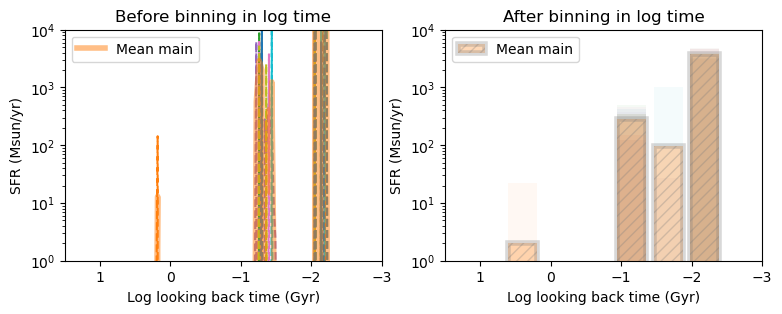

In [56]:
FF_wSED_npSFH_mock10.model_dict['ssp']['specmod'].reconstruct_sfh(num_bins=10)

Please follow the first case (i.e., `FF_wSED_biSFH_mock10`) to obtain the output values of parameters and SFH for `FF_wSED_npSFH_mock10`.

# Emission lines

Show the flux tying ratio of doublets calculated with pyneb under assumption of 100 cm-3, 10000 K electron cloud.

In [42]:
el_mod = copy(FF.model_dict['el']['specmod'])
el_mod.update_lineratio(logden=2, logtem=4)
for i_line in range(el_mod.num_lines):
    if el_mod.lineratio_n[i_line] < 0: continue
    i_ref = np.where(el_mod.linename_n == el_mod.linelink_n[i_line])[0][0]
    print(f'The flux of {el_mod.linename_n[i_line]} is tied to {el_mod.linename_n[i_ref]} with a ratio of {el_mod.lineratio_n[i_line]:2.4f}.')

The flux of [Ne V]:3347 is tied to [Ne V]:3427 with a ratio of 0.3664.
The flux of [O II]:3727 is tied to [O II]:3730 with a ratio of 0.7414.
The flux of H8 is tied to Ha with a ratio of 0.0366.
The flux of [Ne III]:3969 is tied to [Ne III]:3870 with a ratio of 0.3012.
The flux of H7 is tied to Ha with a ratio of 0.0554.
The flux of Hd is tied to Ha with a ratio of 0.0903.
The flux of Hg is tied to Ha with a ratio of 0.1633.
The flux of Hb is tied to Ha with a ratio of 0.3487.
The flux of [O III]:4960 is tied to [O III]:5008 with a ratio of 0.3351.
The flux of [N I]:5199 is tied to [N I]:5202 with a ratio of 0.7828.
The flux of [O I]:6366 is tied to [O I]:6302 with a ratio of 0.3194.
The flux of [N II]:6550 is tied to [N II]:6585 with a ratio of 0.3399.
The flux of [S II]:6718 is tied to [S II]:6733 with a ratio of 1.3496.


Print the best-fit results of emission lines. 
In the table, the three columns represents the three emission line components, which are set in the input `el_config`.
The 1st row is the `chi-square`; 
the 2-5th rows are best-fit values, i.e., `velocity shift`, `width`, `AV (from Balmer decrement)`, 
as well as `electron density` and `temperature`. 
The following rows are the `observed (extinct) fluxes` in `1e-15 erg/s/cm2` 
(`1e-15` is the value of `FF.spec_flux_scale`). 

In [43]:
FF.model_dict['el']['specmod'].print_results()


Best-fit emission line components
|    Par/Line Name     |        NLR         |     outflow_1      |     outflow_2      |
|        Chi^2         |     0.19 +-   0.02 |     0.19 +-   0.02 |     0.19 +-   0.02 |
|     Voff (km/s)      | -  20.89 +-   4.37 | -1046.07 +-  26.73 | -2531.75 +- 142.62 |
|     FWHM (km/s)      |   572.71 +-  14.47 |  1510.04 +-  42.15 |  1883.07 +- 217.16 |
|  AV (Balmer decre.)  |     2.80 +-   0.17 |     1.46 +-   0.23 |     2.88 +-   1.79 |
| log e-density (cm-3) |     2.66 +-   0.09 |     1.30 +-   0.00 |     2.94 +-   1.12 |
| log e-temperature(K) |     4.00 +-   0.00 |     4.00 +-   0.00 |     4.00 +-   0.00 |
|     [Ne V]:3347      |     0.00 +-   0.00 |     0.00 +-   0.00 |     0.00 +-   0.00 |
|     [Ne V]:3427      |     0.00 +-   0.00 |     1.68 +-   0.17 |     0.00 +-   0.00 |
|     [O II]:3727      |     1.03 +-   0.04 |     0.64 +-   0.03 |     0.00 +-   0.00 |
|     [O II]:3730      |     1.03 +-   0.05 |     0.94 +-   0.04 |     0.00 +-   0.00

Results are stored in `FF.model_dict['el']['specmod'].output_el_lcp`. 
`output_el_lcp[i_l, i_c, i_p]` shows the best-fit result of the `(i_p)`-th parameter of the `(i_c)`-th components in the `(i_l)`-th mocked loop.
Components are `NLR`, `outflow_1`, and `outflow_2` in this test case. 
Parameters and the `i_p` numbers are: (0) chi_sq (1) voff (km/s) (2) fwhm (km/s) (3) AV (from Balmer decrement) 
(4) log electron density (cm-3) (5) log electron temperature (K)
(6:) observed flux (`FF.spec_flux_scale` * erg/s/cm2) of each line. 

In [44]:
# for example
output_el_lcp = FF.model_dict['el']['specmod'].output_el_lcp
print('Best-fit narrow line velocity FWHM:', output_el_lcp[:,0,2].mean(), '+-', output_el_lcp[:,0,2].std())

line_name = '[O III]:5008'
i_line = 6+np.where(FF.model_dict['el']['specmod'].linename_n == line_name)[0][0]
print('Best-fit [OIII]5007 outflow_1 flux:', output_el_lcp[:,1,i_line].mean(), '+-', output_el_lcp[:,1,i_line].std())

Best-fit narrow line velocity FWHM: 573.4001656378906 +- 13.797300674686978
Best-fit [OIII]5007 outflow_1 flux: 8.182898693101864 +- 0.30056589190464683


# AGN torus 

Print the best-fit results of AGN torus component. 

In [45]:
FF.model_dict['torus']['specmod'].print_results()


Best-fit properties of torus component: <main>
| Opacity               =    10.9953 +/- 0.0105
| Out/in radii ratio    =    26.0609 +/- 0.3317
| Half OpenAng (degree) =    76.7641 +/- 4.5732
| Inclination (degree)  =    89.9542 +/- 0.0766
| Torus Lum (1e12 Lsun) =     5.7556 +/- 0.3239


Results are stored in `FF.model_dict['torus']['specmod'].output_torus_lcp`. 
`output_el_lcp[i_l, i_c, i_p]` shows the best-fit result of the `(i_p)`-th parameter of the `(i_c)`-th components in the `(i_l)`-th mocked loop.
Since only one component is used in the case, i_c = 0.
Parameters and the `i_p` numbers are: (0) chi_sq (1) voff (km/s) (2) opacity (tau) (3) half opening angel (degree) 
(4) ratio of radius_out to radius_in (5) inclination angle (degree)
(6) the total torus luminosity, in unit of 1e12 Lsun.